# Time Series Analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os.path
import subprocess
import warnings
warnings.filterwarnings('ignore')

Helpers for Getting, Loading and Locating Data

In [2]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Get Data</span>

In [3]:
wget_data('https://raw.githubusercontent.com/illinois-dap/DataAnalysisForPhysicists/main/data/AirPassengers.csv')

--2025-11-07 21:23:05--  https://raw.githubusercontent.com/illinois-dap/DataAnalysisForPhysicists/main/data/AirPassengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1746 (1.7K) [text/plain]
Saving to: ‘./tmp_data/AirPassengers.csv’
     0K .                                                     100% 27.7M=0s
2025-11-07 21:23:05 (27.7 MB/s) - ‘./tmp_data/AirPassengers.csv’ saved [1746/1746]


## <span style="color:Orange">Load Data</span>

In [4]:
df  = pd.read_csv(locate_data('AirPassengers.csv'))
df.columns = ['Date','Number of Passengers']

## <span style="color:Orange">What is a Time Series?</span>

We observe a source not just once, but often have several repeated observations

# $$ (t_1, m_1), (t_2, m_2), ... , (t_N, m_n) $$

A <span style="color:Violet">time-series</span> is any sequene of observation such that the distribution of $m_k$ depends on $m_{k-1}, m_{k-2}...$.
Time is an <span style="color:Violet">exogeneous</span> (outside the model) variable that is <span style="color:Violet">directional</span> - measurements only depend on the past. This is a statement of <span style="color:Violet">causality</span>.

Applies to astronomical measurements, your brain's electrical activity, the stock market, number of infected people...

These observations are typically not uniformly sampled - nor can they be from Earth even in principle (rotation, revolution).

Virtually all statistical methods assume uniform sampling.  



## <span style="color:Orange">Why should you care?</span>

Because everything in the cosmos is dynamic and changing [Figure credit: Francisco Forster (ALeRCE broker team)]:

<img src="https://raw.githubusercontent.com/illinois-dap/DataAnalysisForPhysicists/main/img/TimeSeries-transient_sky.jpg" width=1000 align=left></img><br>

___<span style="color:Violet">EXCERCISE</span>___: What statistical questions can you ask of the following time-series? What jumps out at you? Speculate as to why. How might you model this?

<img src="https://raw.githubusercontent.com/illinois-dap/DataAnalysisForPhysicists/main/img/TimeSeries-cow.png" width=1000 align=left></img><br>

What you are doing is a combination of <span style="color:Violet">trend detection</span>, <span style="color:Violet">forecasting</span>, and <span style="color:Violet">period finding</span>

___<span style="color:Violet">EXCERCISE</span>___: What statistical questions can you ask of the following time-series? When did the earthquake begin and end? When did the main shocks of the Boxing Day Tsunami happen? How far apart are they?

<img src="https://raw.githubusercontent.com/illinois-dap/DataAnalysisForPhysicists/main/img/TimeSeries-tsunami.jpg" width=1000 align=left></img><br>

In [5]:
from IPython.display import IFrame
iframe_url = "https://upload.wikimedia.org/wikipedia/commons/4/4c/2004_Indonesia_Tsunami_edit.gif"
IFrame(src=iframe_url, width=1000, height=275)


What you are doing is a combination of <span style="color:Violet">event finding</span> and <span style="color:Violet">change point detection</span>.

___<span style="color:Violet">EXAMPLE</span>___: Filtering a TimeSeries to detect gravitational waves

For this example, we will make use of the [gwpy](https://gwpy.github.io/docs/1.0.0/index.html) package:

In [7]:
!pip install gwpy

The raw ‘strain’ output of the LIGO detectors is recorded as a `TimeSeries` with contributions from a large number of known and unknown noise sources, as well as possible gravitational wave signals.

In order to uncover a real signal we need to filter out noises that otherwise hide the signal in the data. We can do this by using the `gwpy.signal` module to design a digital filter to cut out low and high frequency noise, as well as notch out fixed frequencies polluted by known artifacts.

First we download the raw strain data from the [GWOSC](https://gwosc.org/) public archive:

In [7]:
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)

Next we can design a zero-pole-gain (ZPK) filter to remove the extranious noise.

First we import the `gwpy.signal.filter_design` module and create a bandpass() filter to remove both low and high frequency content

In [8]:
from gwpy.signal import filter_design
bp = filter_design.bandpass(50, 250, hdata.sample_rate)

Now we want to combine the bandpass with a series of `notch()` filters, so we create those for the first three harmonics of the 60 Hz AC mains power:

In [9]:
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)]

and concatenate each of our filters together to create a single ZPK model:

In [10]:
zpk = filter_design.concatenate_zpks(bp, *notches)

Now, we can apply our combined filter to the data, using `filtfilt=True` to filter both backwards and forwards to preserve the correct phase at all frequencies

In [13]:
hfilt = hdata.filter(zpk, filtfilt=True)

Note: The filter_design methods return digital filters by default, so we apply them using TimeSeries.filter. If we had analogue filters (perhaps by passing `analog=True` to the filter design method), the easiest application would be `TimeSeries.zpk`

The filter_design methods return infinite impulse response filters by default, which, when applied, corrupt a small amount of data at the beginning and the end of our original `TimeSeries`. We can discard those data using the `crop()` method (for consistency we apply this to both data series):

In [14]:
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))

Finally, we can `plot()` the original and filtered data, adding some code to prettify the figure:

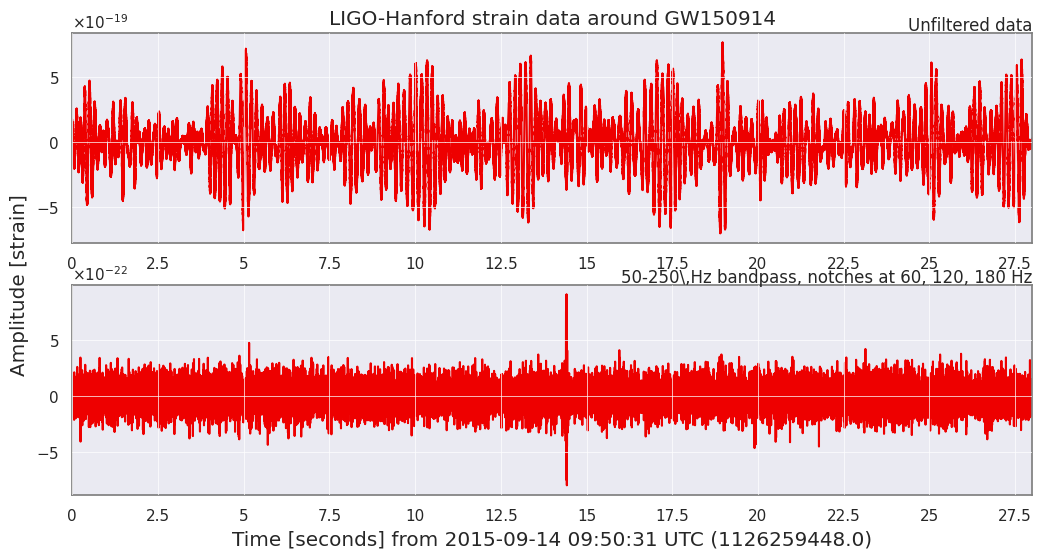

In [15]:
from gwpy.plot import Plot
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

We see now a spike around 16 seconds into the data, so let’s zoom into that time (and prettify):

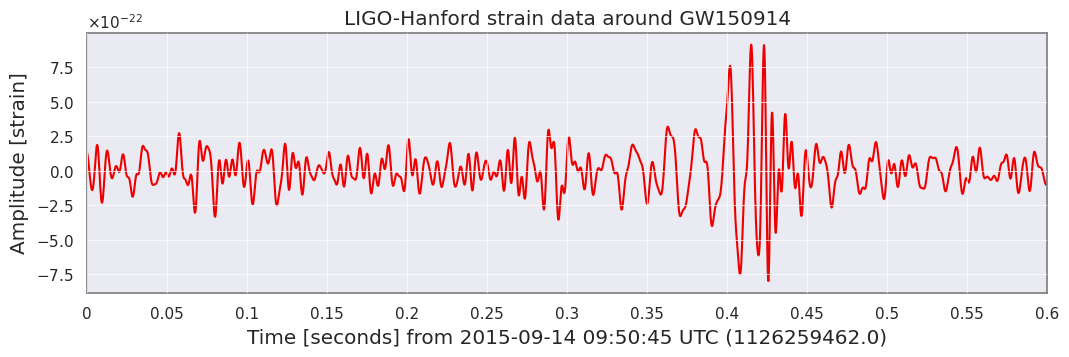

In [16]:
plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
plot.show()

In [17]:
ldata = TimeSeries.fetch_open_data('L1', 1126259446, 1126259478)
lfilt = ldata.filter(zpk, filtfilt=True)

The article announcing the detection told us that the signals were separated by 6.9 ms between detectors, and that the relative orientation of those detectors means that we need to invert the data from one before comparing them, so we apply those corrections:

Congratulations, you have succesfully filtered LIGO data to uncover the first ever directly-detected gravitational wave signal, GW150914! But wait, what about LIGO-Livingston? We can easily add that to our figure by following the same procedure.

First, we load the new data

In [ ]:
lfilt.shift('6.9ms')
lfilt *= -1

and finally make a new plot with both detectors:

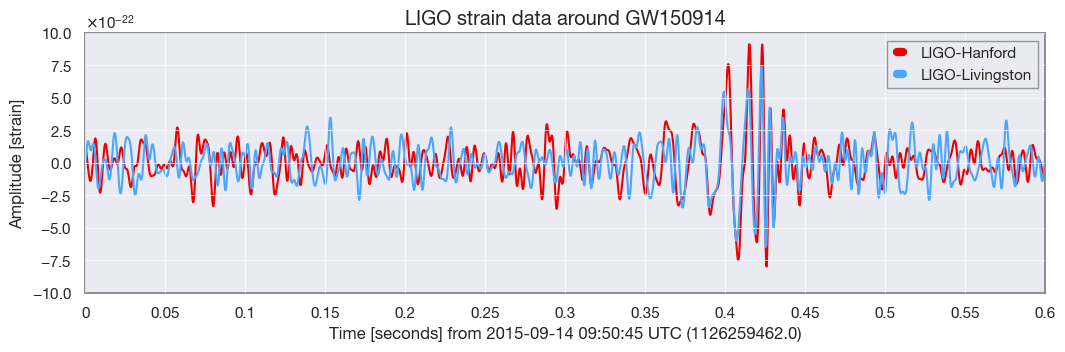

In [ ]:
plot = Plot(figsize=[12, 4])
ax = plot.gca()
ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.set_title('LIGO strain data around GW150914')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-1e-21, 1e-21)
ax.legend()
plot.show()

The above filtering is (almost) the same as what was applied to LIGO data to produce Figure 1 in [Abbott et al. (2016)](https://doi.org/10.1103/PhysRevLett.116.061102) (the joint LSC-Virgo publication announcing this detection).

## <span style="color:Orange">What statistical questions can you ask of a time-series?</span>

1. Trend detection
2. Periodicity detection
3. Event detection
4. Point of change detection
5. Forecasting

All of which are linked to each other.

## <span style="color:Orange">Fourier Series and Fourier Transform</span>

Plotting data in the Fourier domain gives us an idea of the frequency content of the data. You have studied Fourier methods in the previous lecture. Here we give a brief summary given its particular relevance to time series analysis

### <span style="color:LightBlue">Fourier Series</span>

We can approximate a periodic function of period P to arbitrary accuracy by adding sine and cosine terms. This process is known as a Fourier Series, computed as

$$ \Large
f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n \cos(nx) + b_n \sin(nx)
$$

Let's look at the square wave centered at $x=0$

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
pi = np.pi
x = np.linspace(-3*pi, 3*pi, 1000)

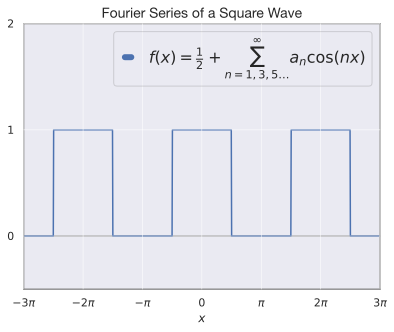

In [ ]:
plt.axhline(0, color='gray', lw=1)
plt.plot(x, 0.5 + 0.5 * signal.square(x + pi/2), lw=1.5,
         label=r'$f(x)=\frac{1}{2} + \sum_{n=1,3,5\ldots}^{\infty}a_n \cos(nx)$')
plt.yticks([-1, 0, 1, 2], ['$-1$', '$0$', '$1$', '$2$'])
plt.xticks([-3*pi, -2*pi, -1*pi, 0, pi, 2*pi, 3*pi], ['$-3\pi$', '$-2\pi$', '$-\pi$', '$0$', '$\pi$', '$2\pi$', '$3\pi$'])
plt.xlim(-3*pi, 3*pi)
plt.ylim(-0.5, 2)
plt.legend(fontsize=16, fancybox=True, framealpha=0.3, loc='best')
plt.rcParams['figure.figsize'] = (11, 4)
plt.rcParams.update({'font.size': 16})
plt.title('Fourier Series of a Square Wave', fontsize=14)
plt.xlabel('$x$')
plt.show()

We now show how to calculate the $a_n$. Let's change our Fourier Series Equation

$$ \Large
f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n \cos(n \omega_0 x) + b_n \sin(n \omega_o x)
$$

where

$$ \Large
\omega_0 =\frac{2\pi}{T}
$$

and $T$ is the fundamental period (for the square wave above, $T=2\pi$)

The equation for $a_n$ is

$$ \Large
a_n = \frac{2}{T}\int_{-T/2}^{T/2} f(x)\cos(n \omega_0 x)dx
$$

For the square wave above, the limits are only $-T/4$ to $T/4$ because $f(x)=0$ for the rest of the wavelength.

$$ \Large
a_n = \frac{2}{T} \int_{-T/4}^{T/4}\cos(n \omega_0 x)dx
$$

Because $\cos(nx)$ is even, we can reduce the limits to $0$ to $T/4$ and multiply by $2$

$$ \Large
a_n = \frac{4}{T} \int_{0}^{T/4}\cos(n \omega_0 x)dx
$$

$$ \Large
a_n = \frac{4}{n \omega_0 T} \sin(n \omega_0 x)\bigg|^{T/4}_0  =\frac{4}{n \omega_0 T}\sin \left( n\omega_0 \frac{T}{4} \right)
$$

$$ \Large
a_n =\frac{2}{n\pi}\sin \left(n \omega_0 \frac{\pi}{2} \right)
$$

And of course we can plot this

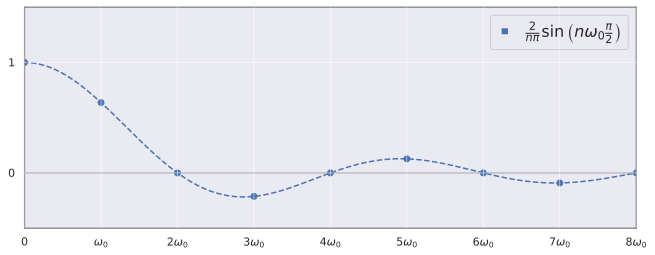

In [ ]:
plt.axhline(0, color='gray', lw=1)
plt.plot(x, 2/(x*pi) * np.sin(x * pi/2), '--', label=r'$\frac{2}{n\pi}\sin \left( n\omega_0 \frac{\pi}{2} \right)$')
an = [2/(n*pi) * np.sin(n * pi/2) for n in range(1, 10)]
plt.plot(0, 1, 'bo')
plt.plot(range(1, 10), an, 'bo')
plt.yticks([-1, 0, 1, 2], ['$-1$', '$0$', '$1$', '$2$'])
plt.xticks(list(range(9)),
          ['$0$', '$\omega_0$', '$2\omega_0$', '$3\omega_0$', '$4\omega_0$',
           '$5\omega_0$', '$6\omega_0$', '$7\omega_0$', '$8\omega_0$'])
plt.xlim(0, 8)
plt.ylim(-0.5, 1.5)
plt.legend(fontsize=16, fancybox=True, framealpha=0.3, loc='best')
plt.show()

### <span style="color:LightBlue">Fourier Transform</span>

1. Fourier Transform is a generalized version of the Fourier Series
2. It applies to both periodic and non periodic functions
   - For periodic functions, the spectrum is discrete
   - For non-period functions, the spectrum is continuous

The Fourier Transform by itself can be powerful if
1. the signal-to-noise is high
2. the signal is continious and uniformly sampled
3. the shape you are modeling is simple and can be decomposed into a few Fourier terms.

Unfortunately, these are not the usual conditions we have in scientific data such as in gravity wave detection, but these will guide our illustration of the concepts.

The Fourier Series becomes the Fourier Transform when
$$ \Large
T \rightarrow \infty, \qquad \omega_0 \rightarrow 0
$$

Some definitions:

<span style="color:Violet">Fourier Transform</span> of $f(x)$ is $F(k)$
$$ \Large
F(k) = \mathcal{FT}\{f(x)\}
$$

$$ \Large
F(k) = \int_{-\infty}^{\infty}f(x) \exp(-ikx)dx
$$

where $k=\frac{2\pi}{x}$ is called the "wavenumber"

<span style="color:Violet">Inverse Fourier Transform</span>

To go back to $f(x)$, the formula is

$$ \Large
f(x) = \mathcal{FT}^{-1}\{F(k)\}
$$

$$ \Large
f(x) = \frac{1}{2\pi} \int_{-\infty}^{\infty}F(k) \exp(ikx)dx
$$

Since $x$ and $k$ are inversely proportional, the "size" of $f(x)$ and $F(k)$ are inversely proportional.
What this means is,
 - a compact $f(x)$ will have a broad spectrum.
 - a broad $f(x)$ will have a compact spectrum

___<span style="color:Violet">Example</span>___: Fourier Transform of $\text{rect}$ function

The "Rectangle function" $rect_B(x)$ function is a rectangle centered at $x=0$ with $\text{Height}=1$ and $\text{Width}=B$. The Formula can be written as

$$
\text{rect}_B(x) =
\begin{cases}
0 & \text{if} \,\,\, |x| > B/2\\[2pt]
1/2 & \text{if} \,\,\, |x| = B/2 \\[2pt]
1 & \text{if} \,\,\, |x| < B/2
\end{cases}
$$

The cell below is a simple function for creating $\text{rect}_B(x)$
Using the FT definition and the $\text{rect}_B(x)$ equation, the FT is

$$
F(k) = \int_{-B/2}^{B/2} \exp(-ikx)dx
$$

$$
= -\frac{1}{ik} \exp(-ikx) \, \Big|_{-B/2}^{\,B/2}
$$

$$
= -\frac{1}{ik} \left[ \exp(-ikB/2) - \exp(ikB/2)\right]
$$

Using the complex definition of sine from Euler's formula

$$
\sin(x) = \frac{e^{ix} - e^{-ix}}{2i}
$$

our equation for $F(k)$ can be re-written as

$$
F(k) = \frac{2}{k}\frac{\exp(ikB/2) - \exp(-ikB/2)}{2i}
$$

$$
= \frac{2}{k} \sin(kB/2)
$$

$$
= B \frac{\sin(kB/2)}{kB/2}
$$


$$
F(k) = B \text{sinc}(kB/2)
$$

___<span style="color:Violet">Example</span>___: Fourier Transform from the scipy docs: FFT of the sum of two sines

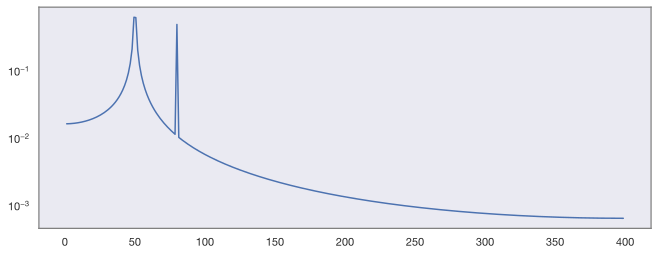

In [ ]:
from scipy.fft import fft, fftfreq
from scipy.signal import blackman

# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)

xf = fftfreq(N, T)[:N//2]

plt.figure()
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
plt.grid()
plt.show()

## <span style="color:Orange">Nyquist Sampling</span>

Nyquist: "In order to recover all Fourier components of a periodic waveform, it is necessary to use a sampling rate fs at least twice the highest waveform frequency"

The above statement requires the user to sample a signal at twice the highest natural frequency of the expected system, or mathematically:

$$ \Large
f_{Nyq} = 2\cdot f_{natural}
$$

Therefore, in the FFT function, the limitation of the frequency component is set by the sample rate, which is typically a little higher than twice the highest natural frequency expected in the system. In the case of acoustics, the sample rates are set at approximately twice the highest frequency that humans are capable of discerning (20 kHz), so the sample rate for audio is at minimum 40 kHz. We often see 44.1 kHz or 48 kHz, which means audio is often sampled correctly above the Nyquist frequency set by the range of the human ear.

Therefore, in practice, it is essential to adhere to the following inequality:

$$ \Large
f_{Nyq} = 2\cdot f_{natural} \rightarrow f_s \geq f_{Nyq}
$$

As a visualization tool, below I have plotted several sampled signals that are sampled around the Nyquist frequency for a sine wave.

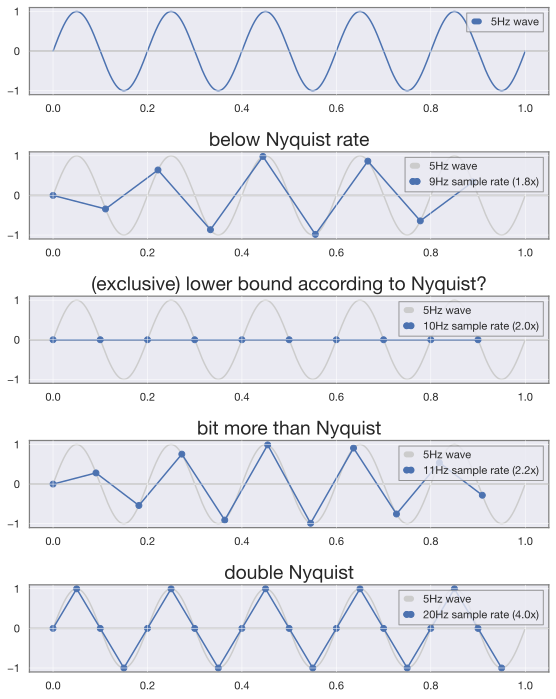

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

wave_freq = 5
domain = 1
# Number of sample points
N = 10000

sample_rates = (
    (wave_freq * 2 - 1, 'below Nyquist rate'),
    (wave_freq * 2, '(exclusive) lower bound according to Nyquist?'),
    (wave_freq * 2 + 1, 'bit more than Nyquist'),
    (wave_freq * 4, 'double Nyquist'),
)

n_plots = len(sample_rates) + 1

fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(n_plots, 1,  1)

x_hi_res = np.linspace(0.0, domain, N, endpoint=False)
hi_res = np.sin(wave_freq * 2.0*np.pi*x_hi_res)
ax.axhline(color="0.7")
ax.plot(x_hi_res, hi_res, label=f'{wave_freq}Hz wave')
ax.legend(loc=1)
ylim = ax.get_ylim()

for i, (sample_rate, title) in enumerate(sample_rates):
    ax = fig.add_subplot(n_plots, 1, i+2)

    x = np.linspace(0.0, domain, sample_rate, endpoint=False)
    samples = np.sin((2 * np.pi * wave_freq) * x)
    ax.axhline(color="0.7")
    ax.plot(x_hi_res, hi_res, label=f'{wave_freq}Hz wave', color='0.8') # show what we're aiming for
    ax.plot(x, samples, marker='o', label=f'{sample_rate}Hz sample rate ({sample_rate/wave_freq}x)')
    ax.set_ylim(*ylim)
    ax.legend(loc=1)
    ax.set_title(title)

fig.tight_layout()

## <span style="color:Orange">Auto-Correlation</span>

<span style="color:Violet">Autocorrelation</span>, sometimes known as serial correlation in the discrete time case, is the correlation of a signal with a delayed copy of itself as a function of delay. Informally, it is the similarity between observations of a random variable as a function of the time lag between them.

The <span style="color:Violet">Autocorrelation Function</span> (ACF) between times $t_1$ and $t_2$ is given by
$$ \Large
\text{ACF}(t_1, t_2) = E[X_{t_1}, \bar{X_{t_2}}]
$$
where where $E$ is the expectation value operator and the bar represents complex conjugation.

The analysis of autocorrelation is a mathematical tool for finding repeating patterns, such as the presence of a periodic signal obscured by noise, or identifying the missing fundamental frequency in a signal implied by its harmonic frequencies. It is often used in signal processing for analyzing functions or series of values, such as time domain signals.

___<span style="color:Violet">EXAMPLE</span>___: Elucidating the sine function

The figures below show a plot of a series of 100 random numbers drawn from a sine function. In the sampling, sine function nature of the data is obscured. The sine function revealed in a correlogram produced by autocorrelation function.

<img src="https://raw.githubusercontent.com/illinois-dap/DataAnalysisForPhysicists/main/img/TimeSeries-Acf_sinx.png" width=600 align=left></img><br>

___<span style="color:Violet">EXAMPLE</span>___: Seasonality of air passenger data?

This dataset provides monthly totals of a US airline passengers from 1949 to 1960. This dataset is taken from an inbuilt dataset called `AirPassengers`.

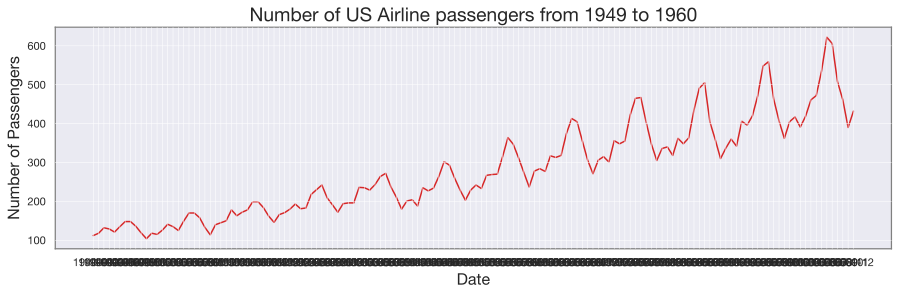

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Passengers', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


plot_df(df, x=df['Date'], y=df['Number of Passengers'], title='Number of US Airline passengers from 1949 to 1960')

Since all the values are positive, we can show this on both sides of the Y axis to emphasize the growth.

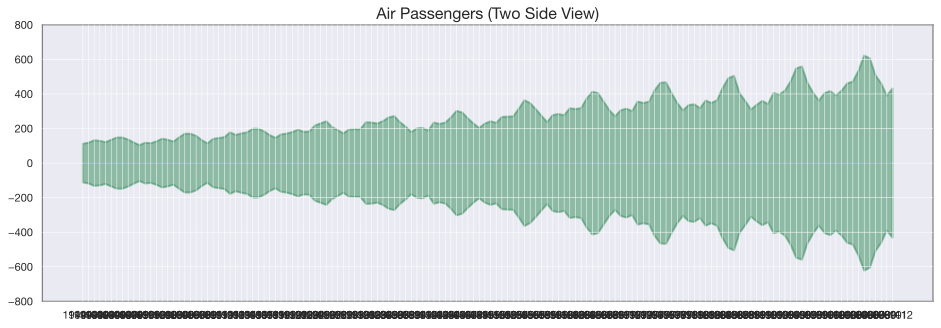

In [ ]:
x = df['Date'].values
y1 = df['Number of Passengers'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Air Passengers (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df['Date']), xmax=np.max(df['Date']), linewidth=.5)
plt.show()

It can be seen that its a monthly time series and follows a certain repetitive pattern every year. So, we could plot each year as a separate line in the same plot, which would let us compare the year wise patterns side-by-side.

The common way to test for seasonality of a time series is to plot the series and check for repeatable patterns in fixed time intervals. So, the types of seasonality is determined by the clock or the calendar.

1. Hour of day
2. Day of month
3. Weekly
4. Monthly
5. Yearly

However, if we want a more definitive inspection of the seasonality, use the Autocorrelation Function (ACF) plot. There is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window.

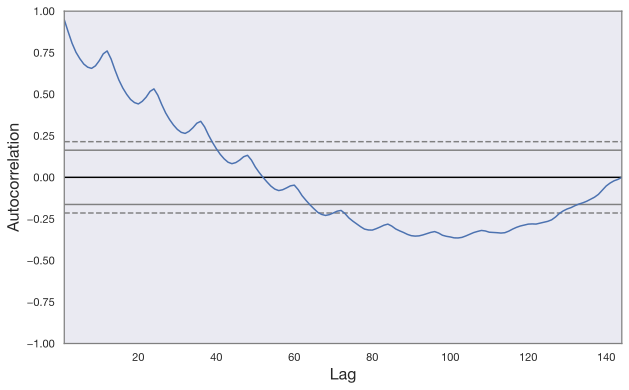

In [ ]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(df['Number of Passengers'].tolist());

### <span style="color:LightBlue">Autocorrelation and Partial Autocorrelation Functions</span>

- <span style="color:Violet">Autocorrelation</span> is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

- <span style="color:Violet">Partial Autocorrelation</span> also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

In [ ]:
!pip install statsmodels

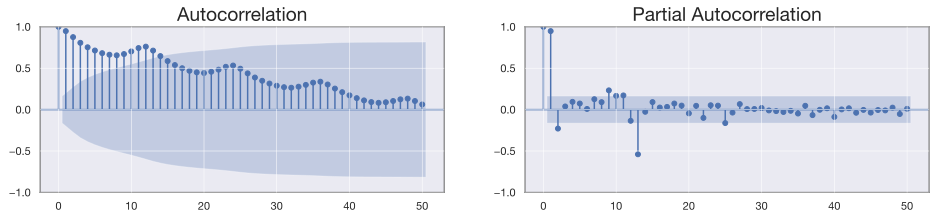

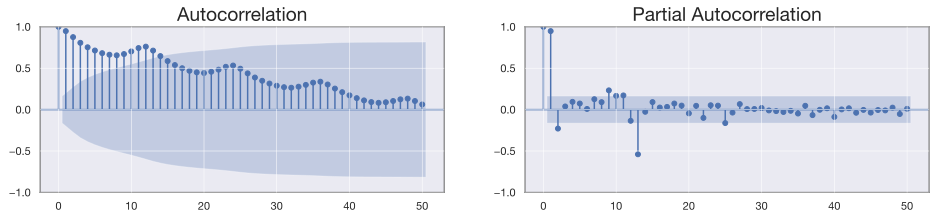

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Number of Passengers'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['Number of Passengers'].tolist(), lags=50, ax=axes[1])

The $y$-axis in the ACF plot is the amount of correlation at each lag $k$. The shaded red region is a confidence interval - if the height of the bars is outside this region, it means the correlation is statistically significant. When a clear trend exists in a time series, the autocorrelation tends to be high at small lags like 1 or 2. When seasonality exists, the autocorrelation goes up periodically at larger lags.

The only difference autocorrelation and partial autocorrelation is the way that the method accounts for the effect that intervening lags have. For example, at lag 3, partial autocorrelation removes the effect lags 1 and 2 have on computing the correlation.

While autocorrelation is useful for analyzing a time series's properties and choosing what type of model to use, partial autocorrelation tells what order of autoregressive model to fit. This topic will be discussed in-depth when we talk about forecasting

### <span style="color:LightBlue">Lag Plots</span>

A <span style="color:Violet">Lag plot</span> is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. If there is any pattern existing in the series, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

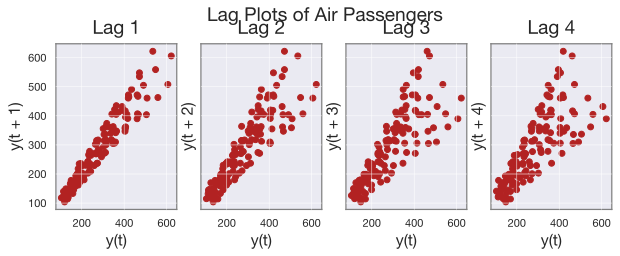

In [ ]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['Number of Passengers'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Air Passengers', y=1.05)
plt.show()

### <span style="color:LightBlue">Cross Correlation</span>

<span style="color:Violet">Cross Correlation</span> is a measure of similarity of two series as a function of the displacement of one relative to the other. This is also known as a _sliding dot product_ or _sliding inner-product_. It is analogous to autocorrelation but it performed between two time series.

The animation below displays how cross correlation is calculated as a function of the shift $\tau$ of time trace $G$. The left graph shows a function $G$ that is phase-shifted relative to function $F$ by a time displacement of $\tau$. The middle graph shows the function $F$ and the phase-shifted $G$ represented together as a Lissajous curve. Integrating $F$ multiplied by the phase-shifted $G$ produces the right graph, the cross-correlation across all values of $\tau$.

In [ ]:
from IPython.display import IFrame
iframe_url = "https://upload.wikimedia.org/wikipedia/commons/7/71/Cross_correlation_animation.gif"
IFrame(src=iframe_url, width=1000, height=275)


### <span style="color:LightBlue">Autoregressive Processes</span>

The partial autocorrelation function of lag ($k$) of a series is the coefficient of that lag in the autoregression equation of $Y$.

The autoregressive equation of $Y$ is nothing but the linear regression of $Y$ with its own lags as predictors.

For example, if $Y_t$ is the current series and $Y_{t-1}$ is the lag 1 of $Y$, then the partial autocorrelation of lag 3 ($Y_{t-3}$) is the coefficient $\alpha_3$ of $Y_{t-3}$ in the following equation:

$$ \Large
Y_t = a_0 + a_1 ~Y_{t-1} + a_2 ~Y_{t-2} + a_3 ~Y_{t-3}
$$

Processes (like time-series) that "retain memory" of previous states, can be described by [autoregressive models](https://en.wikipedia.org/wiki/Autoregressive_model).

We have already encountered one of these: Our old friend the random walk. Every new value in a random walk is given by the preceeding value plus some noise:
$$ \Large
Y_t = Y_{t-1} + \epsilon_t
$$

If the coefficient of $Y_{t-1}$ is $>$ 1 then it is known as a geometric random walk, which is typical of the stock market. These are Markov Chains.

(Recall that not all Markov chains are stationary - they have to be positive recurrent and irreducible - i.e. you have to be able to get from every state to every other state in some finite time - it'd be dull if the stock market was stationary. So, if you interview for a quant position on Wall Street, you tell them that you are an expert in using autoregressive geometric random walks to model stochastic processes.)

In the random walk case above, each new value depends only on the immediately preceeding value. But we can generalized this to include
$p$ values:
$$ \Large
Y_t = \sum \limits_{j=1}^p \alpha_j ~Y_{t-j} + \epsilon_t
$$

We refer to this as an autoregressive (AR) process of order $p$: AR($p$).

For a random walk, we have $p=1$ and the weights are just $a_1 = 1$.

If the data are drawn from a "stationary" process, the $a_j$ satisfy certain conditions.

One thing that we might do then is ask whether a system is more consistent with $a_1 = 0$ or $a_1 = 1$ (noise vs. a random walk).

### <span style="color:LightBlue">Moving Average Processes</span>

A [moving average](https://en.wikipedia.org/wiki/Moving-average_model) (MA) process is similar to an AR process, but instead the value at each time step depends not on the value of previous time step, but rather the perturbations from previous time steps. It is defined as
$$ \Large
Y_t = \epsilon_t + \sum \limits_{j=1}^q b_j ~\epsilon_{t-j}
$$

So, for example, an MA($q$=1) process would look like
$$ \Large
Y_t = \epsilon_t + b_1 ~\epsilon_{t-1}
$$

whereas an AR($p$=2) process would look like
$$ \Large
Y_t = a_1 ~Y_{t-1} + a_2 ~Y_{t-2} + \epsilon_t
$$

### <span style="color:LightBlue">ARMA model</span>

Though both AR and MA models are reasonable and popular choices, the most common time series forecasting method is the <span style="color:Violet">autoregressive moving average</span> [ARMA](https://en.wikipedia.org/wiki/Autoregressive_moving-average_model) method which combines both the AR and MA linear models. These are creatively called ARMA processes.

It can thus be written as:
$$ \Large
Y_t = \epsilon_i + \sum_{j=1}^p a_j \epsilon_{i-j} + \sum_{j=1}^q b_j ~Y_{t-j}
$$

E.g. ARMA(2,1) model, which combines AR(2) and MA(1):

$$ \Large
Y_t = a_1 ~Y_{t-1} + a_2 ~Y_{t-2} + \epsilon_t + b_1 \epsilon_{t-1}
$$

### <span style="color:LightBlue">ARIMA model</span>

The ARMA model doesn't have a mechanism to adjust for trend or seasonality in the data.
A slight adjustment to the model that accounts for the trend is to adjust the moving average of the errors $\epsilon_j$.
This is called the <span style="color:Violet">autoregressive integrating moving average</span> model or [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average).
It can be written as:
$$ \Large
Y_t = \epsilon_i + \sum_{j=1}^{p-d} a_j \epsilon_{i-j} + \sum_{j=1}^q b_j ~Y_{t-j}
$$
where $d$ is an adjustment for the trend.

### ___<span style="color:violet">EXAMPLE</span>___: ___Forcasting Bitcoin Pricing___

<span style="color:violet">Time series forecasting</span> is the task of predicting future values based on historical data. Examples across industries include forecasting of weather, sales numbers and stock prices. More recently, it has been applied to predicting price trends for cryptocurrencies such as Bitcoin and Ethereum. The prevalence of time series forecasting applications exist in many different fields, including scientific research, so we provide a specific example here.

An extension of ARMA is the Autoregressive Integrated Moving Average (ARIMA) model, which doesn’t assume stationarity but does still assume that the data exhibits little to no seasonality. Fortunately, the seasonal ARIMA (SARIMA) variant is a statistical model that can work with non-stationary data and capture some seasonality. We will limit the scope of our example to the ARMA and ARIMA forcasting models.

Python provides many easy-to-use libraries and tools for performing time series forecasting in Python. Specifically, the stats library in Python has tools for building ARMA models, ARIMA models and SARIMA models with just a few lines of code. Since all of these models are available in a single library, you can easily run many Python forecasting experiments using different models in the same script or notebook when conducting time series forecasting in Python.

___Reading and Displaying BTC Time Series Data___

We will start by reading in the historical prices for BTC using the Pandas data reader. Let’s install it using a simple pip command in terminal:

In [ ]:
!pip install pandas-datareader

In [ ]:
!pip install yfinance

 Let’s open up a Python script and import the data-reader from the Pandas library:

In [ ]:
import pandas_datareader.data as web
import datetime

Let's relax the display limits on columns and rows for the Panda library:

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

We can now import the date-time library, which will allow us to define start and end dates for our data pull:

In [ ]:
import datetime

Now we have everything we need to pull Bitcoin price time series data, let’s collect data.

In [ ]:
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

btc = pdr.get_data_yahoo("BTC-USD", start="2018-01-01", end="2020-12-02")['Close']

print(btc.head())

[*********************100%%**********************]  1 of 1 completed
Date
2018-01-01    13657.200195
2018-01-02    14982.099609
2018-01-03    15201.000000
2018-01-04    15599.200195
2018-01-05    17429.500000
Name: Close, dtype: float64


Let’s write our closing price BTC data to a csv file. This way, we can avoid having to repeatedly pull data using the Pandas data reader.

In [ ]:
btc.to_csv("tmp_data/btc.csv")

Now, let’s read in our csv file and display the first five rows:

In order to use the models provided by the stats library, we need to set the date column to be a data frame index. We also should format that date using the to_datetime method:

In [ ]:
btc = pd.read_csv("tmp_data/btc.csv")
print(btc.head())

         Date         Close
0  2018-01-01  13657.200195
1  2018-01-02  14982.099609
2  2018-01-03  15201.000000
3  2018-01-04  15599.200195
4  2018-01-05  17429.500000


In order to use the models provided by the stats library, we need to set the date column to be a data frame index. We also should format that date using the to_datetime method:

In [ ]:
btc.index = pd.to_datetime(btc['Date'], format='%Y-%m-%d')

Let's label the y-axis and x-axis using Matplotlib. We will also rotate the dates on the x-axis so that they’re easier to read:

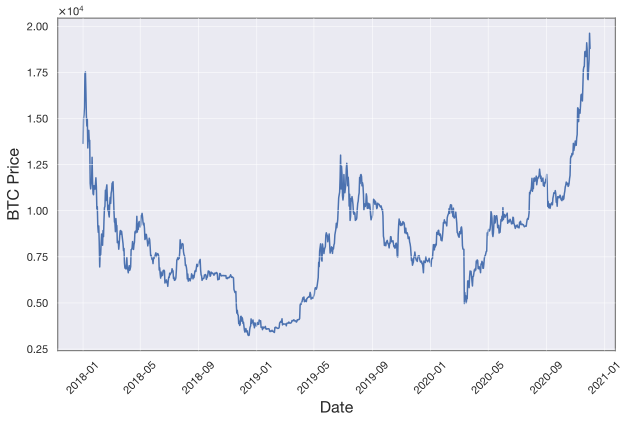

In [ ]:
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['Close']);

Now we can proceed to building our first time series model, the Autoregressive Moving Average.

___Splitting Data for Training and Testing___

An important part of model building is splitting our data for training and testing, which ensures that you build a model that can generalize outside of the training data and that the performance and outputs are statistically meaningful.

We will split our data such that everything before November 2020 will serve as training data, with everything after 2020 becoming the testing data:

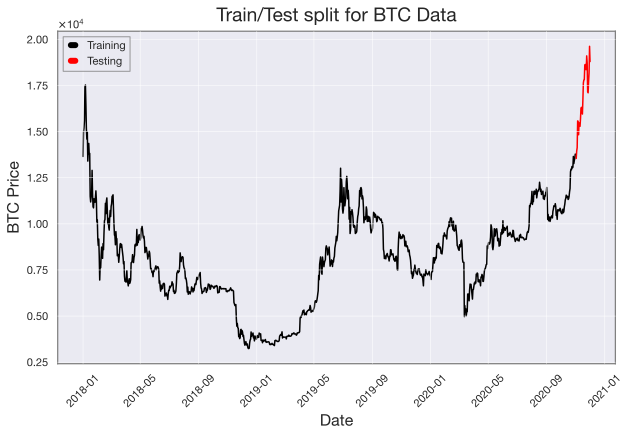

In [ ]:
train = btc[btc.index < pd.to_datetime("2020-11-01", format='%Y-%m-%d')]
test = btc[btc.index > pd.to_datetime("2020-11-01", format='%Y-%m-%d')]

plt.plot(train['Close'], color = "black", label = 'Training')
plt.plot(test['Close'], color = "red", label = 'Testing')
plt.legend()
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

___Autoregressive Moving Average (ARMA)___

The term “autoregressive” in ARMA means that the model uses past values to predict future ones. Specifically, predicted values are a weighted linear combination of past values. This type of regression method is similar to linear regression, with the difference being that the feature inputs here are historical values.

Moving average refers to the predictions being represented by a weighted, linear combination of white noise terms, where white noise is a random signal. The idea here is that ARMA uses a combination of past values and white noise in order to predict future values. Autoregression models market participant behavior like buying and selling BTC. The white noise models shock events like wars, recessions and political events.

We can define an ARMA model using the SARIMAX package:

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Let’s define our input:

In [ ]:
y = train['Close']

And then let’s define our model. To define an ARMA model with the SARIMAX class, we pass in the order parameters of (1, 0 ,1). Alpha corresponds to the significance level of our predictions. Typically, we choose an alpha = 0.05. Here, the ARIMA algorithm calculates upper and lower bounds around the prediction such that there is a 5 percent chance that the real value will be outside of the upper and lower bounds. This means that there is a 95 percent confidence that the real value will be between the upper and lower bounds of our predictions.

In [ ]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


We can then fit our model:

In [ ]:
ARMAmodel = ARMAmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25852D+00    |proj g|=  7.50049D-03

At iterate    5    f=  7.25849D+00    |proj g|=  2.46665D-03

At iterate   10    f=  7.25818D+00    |proj g|=  1.56768D-02

At iterate   15    f=  7.25789D+00    |proj g|=  2.90419D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   2.904D-05   7.258D+00
  F =   7.2578878306587340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


Generate our predictions:

In [ ]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

And plot the results:

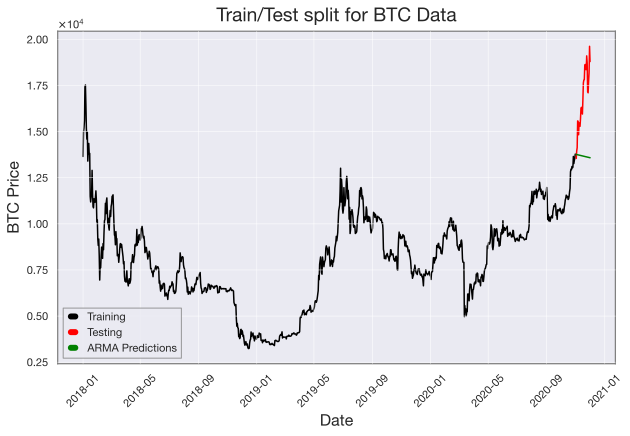

In [ ]:
plt.plot(train['Close'], color = "black", label = 'Training')
plt.plot(test['Close'], color = "red", label = 'Testing')
plt.plot(y_pred_out, color='green', label = 'ARMA Predictions')
plt.legend()
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

We can also evaluate the performance using the root mean-squared error:

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("RMSE: ",rmse)

y_pred_out_ARMA = y_pred_out

RMSE:  3562.1357348230517


The RMSE is pretty high, which we could have guessed upon inspecting the plot. Unfortunately, the model predicts a decrease in price when the price actually increases. Again, ARMA is limited in that it fails for non-stationary time series and does not capture seasonality. Let’s see if we can improve performance with an ARIMA model.

___Autoregressive Integrated Moving Average (ARIMA)___

Let’s import the ARIMA package from the stats library:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

An ARIMA task has three parameters. The first parameter corresponds to the lagging (past values), the second corresponds to differencing (this is what makes non-stationary data stationary), and the last parameter corresponds to the white noise (for modeling shock events).

Let’s define an ARIMA model with order parameters (2,2,2):

In [ ]:
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("RMSE: ",rmse)

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE:  3423.0657143773633


Text(0.5, 1.0, 'Train/Test split for BTC Data')

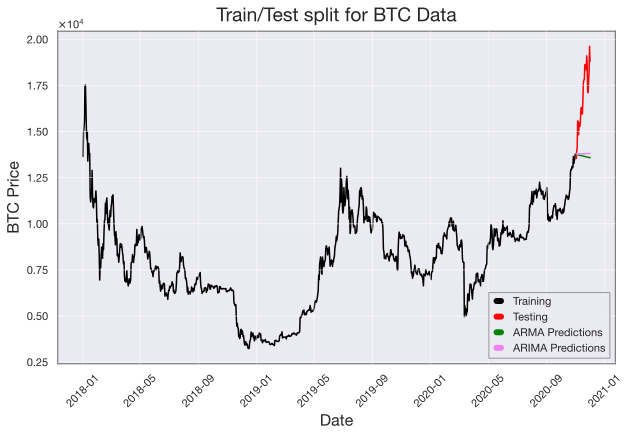

In [ ]:
plt.plot(train['Close'], color = "black", label = 'Training')
plt.plot(test['Close'], color = "red", label = 'Testing')
plt.plot(y_pred_out_ARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_out, color='violet', label = 'ARIMA Predictions')
plt.legend()
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")

We see that the ARIMA predictions (in yellow) fall on top of the ARMA predictions. Let’s try increasing the differencing parameter to ARIMA (2,3,2):

In [ ]:
ARIMAmodel = ARIMA(y, order = (2, 3, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("RMSE: ",rmse)

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE:  3224.970643199179


/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Train/Test split for BTC Data')

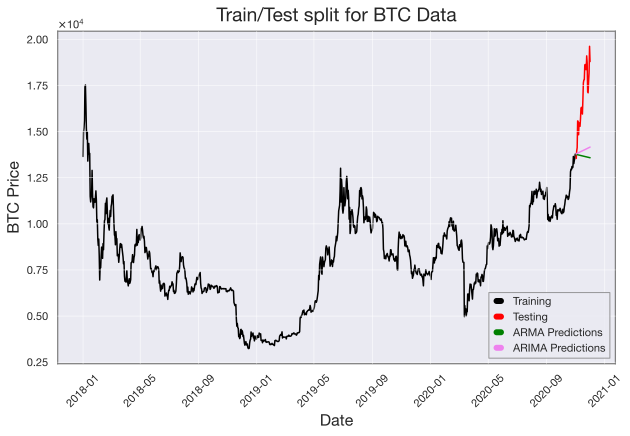

In [ ]:
plt.plot(train['Close'], color = "black", label = 'Training')
plt.plot(test['Close'], color = "red", label = 'Testing')
plt.plot(y_pred_out_ARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_out, color='violet', label = 'ARIMA Predictions')
plt.legend()
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")

We see this helps capture the increasing price direction. Let’s try playing with the parameters even further with ARIMA(6,5,2):

In [ ]:
ARIMAmodel = ARIMA(y, order = (6, 5, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("RMSE: ",rmse)

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE:  1409.74704737552


Text(0.5, 1.0, 'Train/Test split for BTC Data')

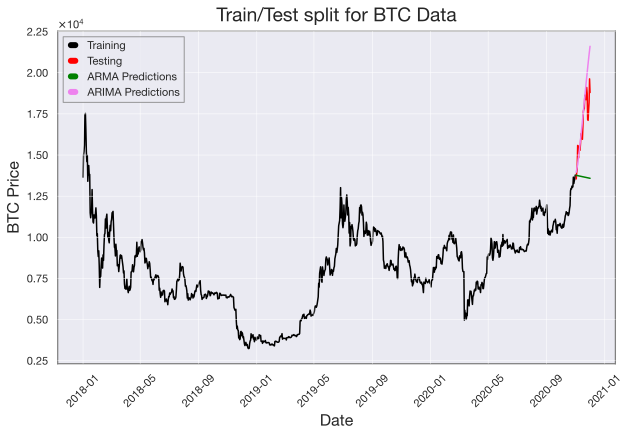

In [ ]:
plt.plot(train['Close'], color = "black", label = 'Training')
plt.plot(test['Close'], color = "red", label = 'Testing')
plt.plot(y_pred_out_ARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_out, color='violet', label = 'ARIMA Predictions')
plt.legend()
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")

---

For amusement and illustration of the limitations of time series forecasting, the plot below includes Bitcoin price data including data after the predictions we made previously and up to November 8, 2023

In [ ]:
btc_now = pdr.get_data_yahoo("BTC-USD", start="2018-01-01", end="2023-11-08")['Close']

[*********************100%%**********************]  1 of 1 completed


In [ ]:
btc_now.to_csv("tmp_data/btc_now.csv")

In [ ]:
btc_now = pd.read_csv("tmp_data/btc_now.csv")

In [ ]:
btc_now.index = pd.to_datetime(btc_now['Date'], format='%Y-%m-%d')
#train_now = btc_now[btc_now.index < pd.to_datetime("2023-11-09", format='%Y-%m-%d')]

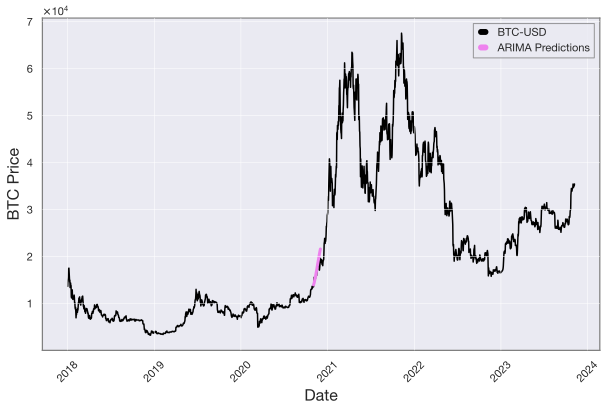

In [ ]:
plt.plot(btc_now['Close'], color = "black", label = 'BTC-USD')
plt.plot(y_pred_out, color='violet', label = 'ARIMA Predictions', linewidth=3)
plt.legend()
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45);

---
## Acknowledgements
* Initial version: Mark Neubauer

© Copyright 2023